# Lecture : Graph Transformers & Graph ViT

## Lab 04 : Graph Transformers with edge features and PyTorch (dense linear algebra) -- Solution

### Xavier Bresson, Guoji Fu

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    !pip install rdkit==2023.09.6 # Install RDKit


In [2]:
# Libraries
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
import os, datetime
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import numpy as np
import math


In [3]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.1.2
NVIDIA GeForce RTX 4090 Laptop GPU
cuda


# Load molecular datasets

Loading data...
dataset/QM9_1.4k_pytorch/
Time: 0.802605152130127
num train data : 1000
atom_dict.idx2word : ['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -']
atom_dict.word2idx : {'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
9 4
train[idx].atom_type : tensor([1, 1, 2, 1, 1, 1, 1])
train[idx].atom_type_pe : tensor([0, 1, 0, 2, 3, 4, 5])
train[idx].bond_type : tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
train[idx].bag_of_atoms : tensor([0, 6, 1, 0, 0, 0, 0, 0, 0])
train[idx].smile:  CC(O)C1CC1C


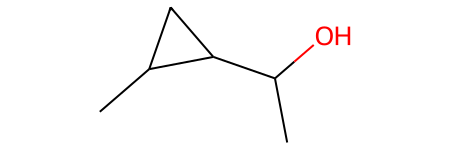

In [4]:
print('Loading data...')
start = time.time()

data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print('num train data :',len(train))

print('atom_dict.idx2word :',atom_dict.idx2word)
print('atom_dict.word2idx :',atom_dict.word2idx)
print('bond_dict.idx2word :',bond_dict.idx2word)
print('bond_dict.word2idx :',bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print('train[idx].atom_type :',train[idx].atom_type)
print('train[idx].atom_type_pe :',train[idx].atom_type_pe)
print('train[idx].bond_type :',train[idx].bond_type)
print('train[idx].bag_of_atoms :',train[idx].bag_of_atoms)
print('train[idx].smile: ',train[idx].smile)
mol = Chem.MolFromSmiles(train[idx].smile)
mol


# Print dataset statistics

In [5]:
# Organize data into group of of molecules of fixed sized
# Example: train[22] is a list containing all the molecules of size 22
def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict
test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[8])) # QM9
# print(len(train_group[28])) # ZINC

# what is the biggest molecule in the train set
max_mol_sz= max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)

# print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try:
            print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
        except:
            pass
print('Train'); print_distribution(train_group)
print('Val'); print_distribution(val_group)
print('Test'); print_distribution(test_group)


136
Max num atoms =  9
Train
number of molecule of size 4: 	 1
number of molecule of size 5: 	 1
number of molecule of size 6: 	 7
number of molecule of size 7: 	 24
number of molecule of size 8: 	 136
number of molecule of size 9: 	 831
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


# Generate batch of pytorch molecules of same size

### Implement the molecule sampler class for batch sampling of molecules

In [6]:
# A class to help drawing batches of molecules having the same size
class MoleculeSampler:
    def __init__(self, organized_dataset, bs , shuffle=True):
        self.bs = bs
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.counter = { sz: 0   for sz in organized_dataset }
        if shuffle:
            self.order = { sz: np.random.permutation(num)  for sz , num in self.num_mol.items() }
        else:
            self.order = { sz: np.arange(num)  for sz , num in self.num_mol.items() }

    def compute_num_batches_remaining(self):
        #return {sz:  ( self.num_mol[sz] - self.counter[sz] ) // self.bs  for sz in self.num_mol}
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol}

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   )
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum( num_batches.values() ) == 0

    def draw_batch_of_molecules(self, sz):
        num_batches = self.compute_num_batches_remaining()
        if (self.num_mol[sz] - self.counter[sz])/self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz]//self.bs) * self.bs
        #print('sz, bs',sz, bs)
        indices = self.order[sz][ self.counter[sz] : self.counter[sz] + bs]
        self.counter[sz] += bs
        return indices


### Extract one mini-batch

In [7]:
# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
while(not sampler.is_empty()):
    num_batches_remaining = sampler.compute_num_batches_remaining()
    print('num_batches_remaining :',num_batches_remaining)
    sz = sampler.choose_molecule_size()
    print('sz :',sz)
    indices = sampler.draw_batch_of_molecules(sz)
    print('indices :',len(indices),indices)
    minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] )
    print('minibatch_node :',minibatch_node.size())
    minibatch_pe  = torch.stack( [ train_group[sz][i].atom_type_pe  for i in indices] )
    print('minibatch_pe :',minibatch_pe.size())
    minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] )
    print('minibatch_edge :',minibatch_edge.size())
    minibatch_boa = torch.stack( [ train_group[sz][i].bag_of_atoms for i in indices] )
    print('minibatch_boa :',minibatch_boa.size())
    break
    print('---------------------------------------')


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 8
indices : 50 [109  82   1  63  21  72  94  14 122  66  77  97  30  65 131  11 103  74
  67 124  35 125  39 130  29  41  12  43  98  56  27  96  54 132  48  85
  73  89  95  16 111 121 123  24  52  91  57  93 115  17]
minibatch_node : torch.Size([50, 8])
minibatch_pe : torch.Size([50, 8])
minibatch_edge : torch.Size([50, 8, 8])
minibatch_boa : torch.Size([50, 9])


### Compute valid molecules

In [8]:
# A class to sample a molecule size w.r.t. the train distribution
class sample_molecule_size:
    def __init__(self, organized_dataset):
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.num_batches_remaining = { sz:  self.num_mol[sz]  for sz in self.num_mol }
    def choose_molecule_size(self):
        num_batches = self.num_batches_remaining
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   )
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

sampler_size = sample_molecule_size(train_group)
print('sampler_size.num_mol :',sampler_size.num_mol)
sz = sampler_size.choose_molecule_size()
print('sz :',sz)


sampler_size.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
sz : 9


# Exercise 1: Design the class of dense GraphTransformer networks with edge features

Node update equation:  
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell}),\textrm{LN}(e^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell}))  \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h,e)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k,e_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{N\times N\times d'}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h,e)_i= \sum_{j\in V} \underbrace{\frac{\exp(q_i^T \textrm{diag}(e_{ij}) k_j/\sqrt{d'})}{ \sum_{j'\in V} \exp(q_i^T \textrm{diag}(e_{ij'}) k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score w/ edge feature}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, E=e_k W_E\in \mathbb{R}^{E\times d'=d/H}, W_Q, W_K, W_V, W_E\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}

Edge update equation:  
\begin{eqnarray*}
\bar{e}^{\ell} &=&  e^{\ell} + \textrm{gMHE} (\textrm{LN}(e^{\ell}),\textrm{LN}(h^{\ell}))  \in \mathbb{R}^{N\times N\times d}\\
e^{\ell+1} &=& \bar{e}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{e}^{\ell})) \in \mathbb{R}^{N\times N\times d}\\
&&\textrm{with } \textrm{gMHE}(e,h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHE}(e_k,h_k) \right) W_O^e \in \mathbb{R}^{N\times N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{N\times N\times d'}, W_O^e\in \mathbb{R}^{d\times d} \\
&&\textrm{with } \textrm{gHE}(e,h)_{ij}=q_i \odot e_{ij} \odot k_j/\sqrt{d'} \in \mathbb{R}^{d'} \textrm{ (point-wise equation)}\\
e^{\ell=0} &=& \textrm{LL}(e_0) \in \mathbb{R}^{N\times N\times d}\ \textrm{(input edge feature)}\\
\end{eqnarray*}

Differences between sparse GT and dense GT:
- The edge features are now dense : Sparse $e\in \mathbb{R}^{E\times d}$ to $e\in \mathbb{R}^{N\times N\times d}$.
- The absence of edges in the graph is now considered as a bond type e.g. `None` type with integer value `0`.
- The attention function is now connected to all nodes in the graph : Sparse attention with $\sum_{j\in \mathcal{N}_i}$ to dense attention $\sum_{j\in V}$.


In [9]:
# Global constants
num_heads = 8; d = 16*num_heads; num_layers = 4; drop = 0.0; bs = 50
print('d, num_heads, num_layers, drop : ', d, num_heads, num_layers, drop)

# Warmup
num_mol_size = 20
num_warmup = 2 * max( num_mol_size, len(train) // bs ) # 4 epochs * max( num_mol_size=20, num_mol/batch_size)
print('num_warmup :',num_warmup)


d, num_heads, num_layers, drop :  128 8 4 0.0
num_warmup : 40


### Implement the Graph Transformer architecture

In [10]:
# Define Graph Transformer architecture
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)

    def forward(self, x, e):
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1) # [bs, n, n]
        Att = self.drop_att(Att)
        x = Att @ V  # [bs, n, d_head]
        return x, e

### Question 1.1: Implement a **dense** Graph Multi-Head Attention (MHA) Layer with Pytorch

**Instructions:**

- *Step 1:* Pass node feature and edge features along edges.

- *Step 2:* Update node feature and edge features. You may use ```torch.cat()``` for concatenating vectors.

In [11]:
class MHA(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
        self.drop_e = nn.Dropout(drop)

    def forward(self, x, e):
        x_MHA = []
        e_MHA = []
        for head in self.heads:
            ###############################################
            # YOUR CODE STARTS
            ###############################################
            # Step 1: Pass node feature and edge features along edges.
            x_HA, e_HA = head(x,e)
            ###############################################
            # YOUR CODE ENDS
            ###############################################

            x_MHA.append(x_HA)
            e_MHA.append(e_HA)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 2: Update node features
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)

        # Step 2: Update edge features
        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return x, e



### Question 1.2: Implement a **dense** GraphTransformer layer

**Instructions:**

- *Layer normalization:* Intialize two layer normalization ```nn.LayerNorm(input_dim)``` for  edge features.

- *Input embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input edge features into edge embeddings.

- *Graph transformer layer:* Initialize a graph Transformer layer using the defined ```MHA()``` class.

- *MLP layer:* Initialize a MLP layer ```nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, output_dim))``` for edge features.

In [12]:
class BlockGT(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        # Intialize two layer normalization for node features
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)

        # Intialize a MLP layer for node features
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))

        # Intialize the graph Transformer layer
        self.MHA = MHA(d, num_heads)

        # Intialize a dropout layer for node features
        self.drop_x_mlp = nn.Dropout(drop)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Intialize two layer normalization for edge features
        self.LNe = nn.LayerNorm(d)
        self.LNe2 = nn.LayerNorm(d)

        # Intialize a MLP layer for edge features
        self.MLPe = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))

        # Intialize a dropout layer for edge features
        self.drop_x_mlp = nn.Dropout(drop)
        self.drop_e_mlp = nn.Dropout(drop)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    def forward(self, x, e):
        # Implement layer normalization for node and edge features, respectively
        x = self.LNx(x)
        e = self.LNe(e)

        # Implement graph Transformer
        x_MHA, e_MHA = self.MHA(x, e) # [bs, n, d], [bs, n, n, d]

        # Implement residual connection layers for node features
        x = x + x_MHA # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]

        x = self.drop_x_mlp(x)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Implement residual connection and dropout for edge features like the above operators for node features
        e = e + e_MHA
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]
        e = self.drop_e_mlp(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return x, e



In [13]:
def sym_tensor(x):
    x = x.permute(0,3,1,2)
    triu = torch.triu(x,diagonal=1).transpose(3,2)
    mask = (triu.abs()>0).float()
    x =  x * (1 - mask ) + mask * triu
    x = x.permute(0,2,3,1)
    return x

class GT(nn.Module):
    def __init__(self):
        super().__init__()
        self.atom_emb = nn.Embedding(num_atom_type, d)
        self.bond_emb = nn.Embedding(num_bond_type, d)
        num_layers_encoder = 4
        self.BlockGT_encoder_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_encoder)] )
        self.ln_x_final = nn.LayerNorm(d)
        self.linear_x_final = nn.Linear(d, 1, bias=True)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_e_emb = nn.Dropout(drop)
    def forward(self, x, e):

        # input layer
        x = self.atom_emb(x)                   # [bs, n, d]
        e = self.bond_emb(e)                   # [bs, n, n, d]
        e = sym_tensor(e)                      # [bs, n, n, d]
        x = self.drop_x_emb(x)
        e = self.drop_e_emb(e)

        # encoder
        for gt_layer in self.BlockGT_encoder_layers:
            x, e = gt_layer(x, e)  # [bs, n, d],  [bs, n, n, d]
            e = sym_tensor(e)

        # class token
        mol_token = x.mean(1) # [bs, d]

        # regressor
        x = self.ln_x_final(mol_token)
        x = self.linear_x_final(x)

        return x

try:
    del net
except:
  print("First run")



First run


### Instantiate a **dense** graph Transformer network

In [14]:
# Instantiate the network
net = GT()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)




Number of parameters: 1588225 (1.59 million)


### Test the forward pass, backward pass and gradient update with a single batch

In [15]:
# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :',sz)
indices = sampler.draw_batch_of_molecules(sz)
print('indices :',len(indices),indices)
batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
print('minibatch_node :',minibatch_node.size())
batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
print('minibatch_edge :',minibatch_edge.size())
batch_target = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
print('batch_target :',batch_target.size())

batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
print('batch_x_pred',batch_x_pred.size())

loss = nn.L1Loss()(batch_x_pred, batch_target)
optimizer.zero_grad()
loss.backward()
optimizer.step()


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 9
indices : 50 [716 180 675 669 776  81 361 439 690   7 167 335 757 778 496 349   3 137
 555 190  87 515 545 441 260 214 552 482 643 432 172  97 616 205 116 192
 433 339 101 536 570 285 513 800 423 715  50 198 726 614]
minibatch_node : torch.Size([50, 9])
minibatch_edge : torch.Size([50, 9, 9])
batch_target : torch.Size([50, 1])
batch_x_pred torch.Size([50, 1])


### Train the network

In [16]:
# Training loop
del net
net = GT()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
init_lr = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/num_warmup, 1.0) ) # warmup scheduler
scheduler_tracker = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True) # tracker scheduler

num_warmup_batch = 0

# Number of mini-batches per epoch
nb_epochs = 100

lossMAE = nn.L1Loss()

print('num batch(before scheduler_tracker), num epoch(before scheduler_tracker), num_warmup_batch(current):', \
      num_warmup, num_warmup//(len(train)//bs), num_warmup_batch)

total_loss = moving_loss = -1
list_loss = []
start=time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0
    num_data = 0
    net.train()

    bs = 50
    sampler = MoleculeSampler(train_group, bs)
    #print('sampler.num_mol :',sampler.num_mol)
    while(not sampler.is_empty()):
        num_batches_remaining = sampler.compute_num_batches_remaining()
        #print('num_batches_remaining :',num_batches_remaining)
        sz = sampler.choose_molecule_size()
        #print('sz :',sz)
        indices = sampler.draw_batch_of_molecules(sz)
        bs2 = len(indices)
        #print('indices :',len(indices),indices)
        batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
        #print('minibatch_node :',minibatch_node.size())
        batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
        #print('minibatch_edge :',minibatch_edge.size())
        batch_target = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]

        batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]

        loss = lossMAE(batch_x_pred, batch_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if num_warmup_batch < num_warmup:
            scheduler_warmup.step() # warmup scheduler
        num_warmup_batch += 1

        # COMPUTE STATS
        running_loss += bs2 * loss.detach().item()
        num_batches += 1
        num_data += bs2


    # TEST SET
    bs = 50
    sampler = MoleculeSampler(test_group, bs)
    running_test_loss = 0
    num_test_data = 0
    with torch.no_grad():
        while(not sampler.is_empty()):
            num_batches_remaining = sampler.compute_num_batches_remaining()
            sz = sampler.choose_molecule_size()
            indices = sampler.draw_batch_of_molecules(sz)
            bs2 = len(indices)
            batch_x0 = minibatch_node = torch.stack( [ test_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
            batch_e0 = minibatch_edge = torch.stack( [ test_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
            batch_target = torch.stack( [ test_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
            batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
            running_test_loss += bs2 * lossMAE(batch_x_pred, batch_target).detach().item()
            num_test_data += bs2


    # AVERAGE STATS THEN DISPLAY
    mean_train_loss = running_loss/num_data
    mean_test_loss = running_test_loss/num_test_data
    if num_warmup_batch >= num_warmup:
        scheduler_tracker.step(mean_train_loss) # tracker scheduler defined w.r.t. loss value
        num_warmup_batch += 1
    elapsed = (time.time()-start)/60
    if not epoch%1:
        line = 'epoch= ' + str(epoch) + '\t time= ' + str(elapsed)[:6] + ' min' + '\t lr= ' + \
        '{:.7f}'.format(optimizer.param_groups[0]['lr']) + '\t train_loss= ' + str(mean_train_loss)[:6] + \
        '\t test_loss= ' + str(mean_test_loss)[:6]
        print(line)

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-6: # 2*10**-4: quick, # 10**-6: slow
      print("\n lr is equal to min lr -- training stopped\n")
      break



Number of parameters: 1588225 (1.59 million)
num batch(before scheduler_tracker), num epoch(before scheduler_tracker), num_warmup_batch(current): 40 2 0
epoch= 0	 time= 0.0525 min	 lr= 0.0000625	 train_loss= 1.3633	 test_loss= 1.3016
epoch= 1	 time= 0.0957 min	 lr= 0.0001000	 train_loss= 1.3443	 test_loss= 1.4513
epoch= 2	 time= 0.1466 min	 lr= 0.0001000	 train_loss= 1.3040	 test_loss= 1.2800
epoch= 3	 time= 0.1949 min	 lr= 0.0001000	 train_loss= 1.2996	 test_loss= 1.2528
epoch= 4	 time= 0.2349 min	 lr= 0.0001000	 train_loss= 1.2899	 test_loss= 1.2430
epoch= 5	 time= 0.2719 min	 lr= 0.0001000	 train_loss= 1.3246	 test_loss= 1.2326
epoch= 6	 time= 0.3096 min	 lr= 0.0001000	 train_loss= 1.2569	 test_loss= 1.2545
epoch= 7	 time= 0.3494 min	 lr= 0.0001000	 train_loss= 1.2601	 test_loss= 1.2312
epoch= 8	 time= 0.3879 min	 lr= 0.0001000	 train_loss= 1.2281	 test_loss= 1.2485
epoch= 9	 time= 0.4243 min	 lr= 0.0001000	 train_loss= 1.2320	 test_loss= 1.1943
Epoch 00010: reducing learning rate o

## Compare results

| GNN    | train MAE | test MAE |
| -------- | ------- | ------- |
| Sparse GT (DGL)   | 0.4483    | 0.7327    |
| Dense GT (PyTroch)    | 0.5464   | 0.6954    |
